# Random Forest Model Implemented to analysis the Relationship among the data Catergorically

In [1]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import sklearn as skl
from sklearn.model_selection import train_test_split, GridSearchCV
from load_data import load_categorical_data
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification
from sklearn.metrics import r2_score
from scipy.stats import ttest_ind as ttest
from sklearn.metrics import mean_squared_error
import time

In [2]:
import openpyxl 
import os

In [3]:
def MinMaxNormal(df):
    normalized_df=(df-df.min())/(df.max()-df.min())
    return normalized_df

In [4]:
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true=np.array(y_true)
    y_pred=np.array(y_pred)
    MSPE = (sum((MinMaxNormal(y_true)-MinMaxNormal(y_pred))**2)/(y_pred.size))/(MinMaxNormal(y_true).mean())
    MSPE = MSPE*100
    return np.abs(MSPE)

In [5]:
"""
Use Decision Tree to fit the relationship between 
homeless_real_value and other variables, except 
no_longer_homeless, prevention_duty, and relief duty.
"""

#Read data
categorical_data,local_authority_names,total_duty_owed,total_population_in_households,prevention_duty_owed,relief_duty_owed,support_need_homeless,no_longer_homeless,homeless_real_value,categorical_waiting_list_size,social_housing_lettings_2020,band_A_B_properties,band_C_D_properties,band_E_F_properties,band_G_H_properties,median_prices,median_earning_gross,categorical_median_afforability_ratio,lower_quatile_prices,lower_quatile_earning_gross,categorical_lower_quatile_afforability_ratio = load_categorical_data()

#social_housing_start,intermediate_start,total_affordable_start,affordable_complete,social_complete,intermediate_complete,total_affordable_complete=load_categorical_more_data()

In [68]:
data_table=categorical_data.drop(labels='Local',axis=1)
data_table=data_table.drop(labels='Local_Authority_code',axis=1)
data_table=data_table.drop(labels='Local_Authority_name',axis=1)
#data_table=data_table.drop(labels='Homeless_(including_intentionally_homeless)',axis=1)
data_table=data_table.drop(labels='Threatened_with_homelessness_within_56_days_Prevention_duty_owed',axis=1)
data_table=data_table.drop(labels='Homeless_Relief_duty_owed4',axis=1)
data_table=data_table.drop(labels='Total_households_with_support_needs',axis=1)
data_table=data_table.drop(labels='Total_secured_accommodation',axis=1)
#data_table=data_table.drop(labels='Intermediate_Rent_(Starts_on_Site)',axis=1)
#data_table=data_table.drop(labels='Intermediate_Rent(Completions)',axis=1)
#data_table=data_table.drop(labels='Affordable_Home_Ownership(Starts_on_Site)',axis=1)
#data_table=data_table.drop(labels='Affordable_Home_Ownership(Completions)',axis=1)
#data_table=data_table.drop(labels='Market(Starts_on_Site)',axis=1)
#data_table=data_table.drop(labels='Market(Completions)',axis=1)
#data_table=data_table.drop(labels='C_D_property_counts',axis=1)
#data_table=data_table.drop(labels='E_F_property_counts',axis=1)
#data_table=data_table.drop(labels='G_H_property_counts',axis=1)
#data_table=data_table.drop(labels='median_houses_2020',axis=1)
#data_table=data_table.drop(labels='median_earning_2020',axis=1)
#data_table=data_table.drop(labels='ratio_by_medians_2020',axis=1)
#data_table=data_table.drop(labels='Total_Affordable(Starts_on_Site)',axis=1)
#data_table=data_table.drop(labels='Total_Affordable(Completions)',axis=1)
#data_table=data_table.drop(labels='Total(Starts_on_Site)',axis=1)
#data_table=data_table.drop(labels='Total(Completions)',axis=1)
#data_table=data_table.drop(labels='lower_quatile_houses_2020',axis=1)
#data_table=data_table.drop(labels='lower_quatile_earning_2020',axis=1)

In [69]:
feature_space = data_table.iloc[:, data_table.columns != 'Total_owed_a_prevention_or_relief_duty'].astype('float')
feature_class = data_table.iloc[:, data_table.columns == 'Total_owed_a_prevention_or_relief_duty'].astype('int')

In [70]:
training_set, test_set, class_set, test_class_set = train_test_split(feature_space,
                                                                    feature_class,
                                                                    test_size = 0.20, 
                                                                    random_state = 10)

# Cleaning test sets to avoid future warning messages
normal_class_set = class_set
class_set = normal_class_set.values.ravel() 
normal_test_class_set = test_class_set
test_class_set = normal_test_class_set.values.ravel() 

In [71]:
# Set the random state for reproducibility
fit_rf = RandomForestClassifier(random_state=0)

In [115]:
# Set best parameters given by grid search 
fit_rf = fit_rf.set_params(bootstrap = True,n_estimators = 400,criterion = 'entropy',
                  max_features = 'auto', 
                  max_depth = 5)

In [116]:
hundredYard_forest = fit_rf.fit(training_set, class_set)

In [117]:
predictions = hundredYard_forest.predict(test_set)

In [118]:
feature_importance_score = list(hundredYard_forest.feature_importances_)

In [119]:
print('SL Model R2 Score: '+str(r2_score(test_class_set,predictions)))

coef = np.corrcoef(test_class_set,predictions)
coef = coef[0,1]
print('SL Model Correlation Coefficient: '+str(coef))

SLMSPE = mean_absolute_percentage_error(test_class_set,predictions)
print('SL Mean Squared Percentage Error: '+str(SLMSPE))

SL Model R2 Score: 0.7310354573385521
SL Model Correlation Coefficient: 0.8829725841711706
SL Mean Squared Percentage Error: 5.164578483530898


In [120]:
socre_data_score = pd.DataFrame(feature_importance_score)
socre_data_score.index = hundredYard_forest.feature_names_in_[:]
socre_data_score = socre_data_score.sort_values(by=[0])

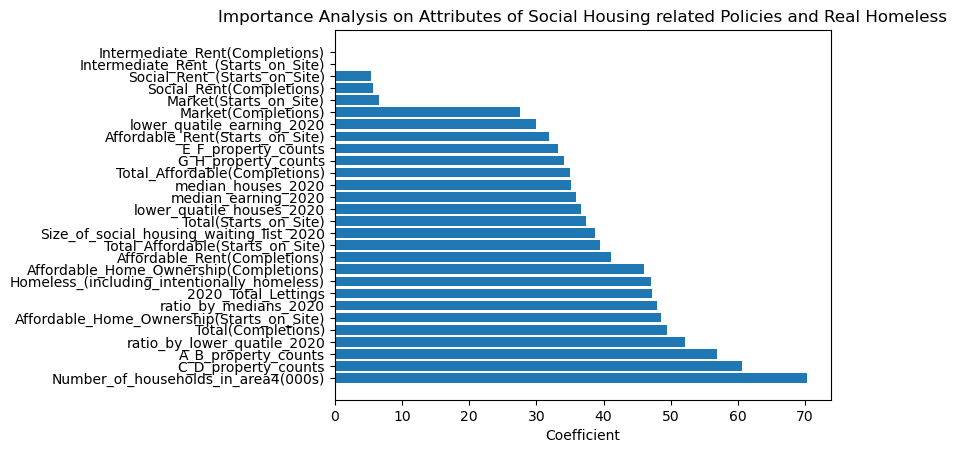

In [121]:

plt.rcdefaults()
fig, ax = plt.subplots()

feature_importance_score = np.array(socre_data_score[0])

# Example data
x_names = list(socre_data_score.index[:])
y_pos = np.arange(len(x_names))

ax.barh(y_pos, feature_importance_score*1000, align='center')
ax.invert_yaxis()  # labels read top-to-bottom
ax.set_yticks(y_pos)
ax.set_yticklabels(list(x_names))
ax.set_xlabel('Coefficient')
ax.set_title('Importance Analysis on Attributes of Social Housing related Policies and Real Homeless')
plt.savefig('Figure/random_forest_importance_score_analysis.png')
plt.show()

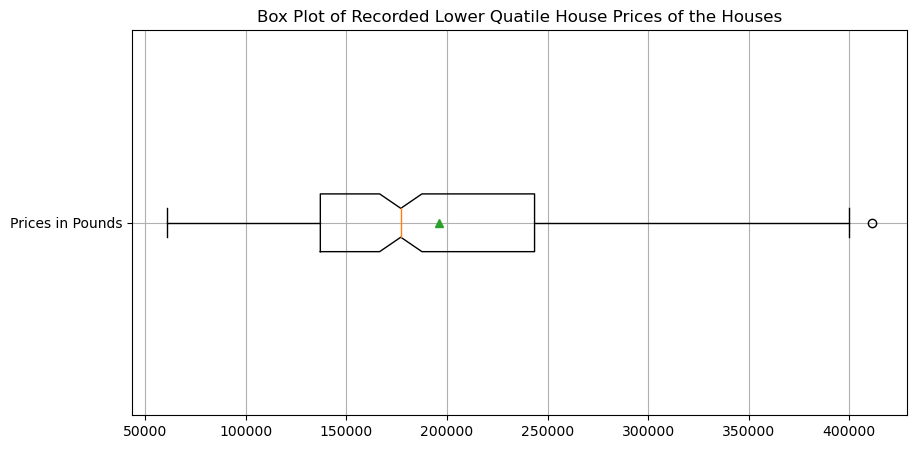

In [122]:
fig_box, ax_box = plt.subplots(figsize=(10,5))
ax_box.grid(zorder=0)
ax_box.set_title('Box Plot of Recorded Lower Quatile House Prices of the Houses')
ax_box.boxplot(data_table['lower_quatile_houses_2020'],showmeans=True, vert=False,notch=True,zorder=2)
ax_box.set_yticklabels(['Prices in Pounds'])
plt.savefig('Figure/lq_house_prices_data.png')

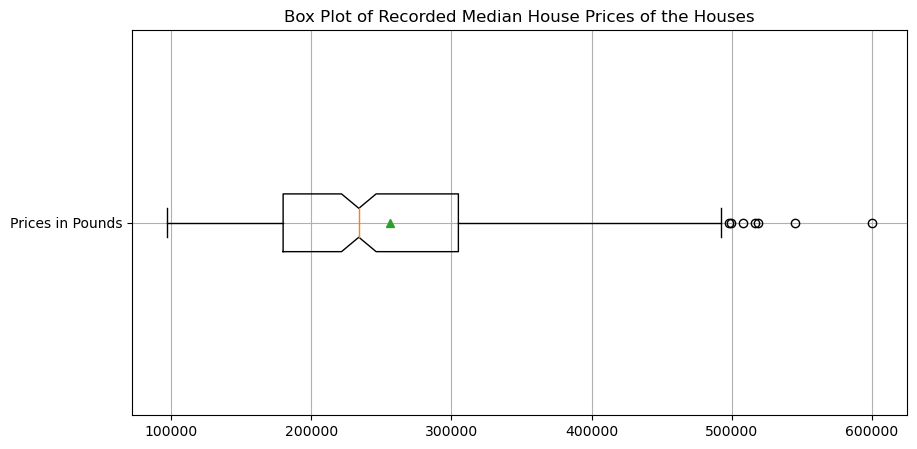

In [123]:
fig_box, ax_box = plt.subplots(figsize=(10,5))
ax_box.grid(zorder=0)
ax_box.set_title('Box Plot of Recorded Median House Prices of the Houses')
ax_box.boxplot(data_table['median_houses_2020'],showmeans=True, vert=False,notch=True,zorder=2)
ax_box.set_yticklabels(['Prices in Pounds'])
plt.savefig('Figure/median_house_prices_data.png')

In [86]:
feature_importance = pd.DataFrame(feature_importance_score)
feature_importance.columns = ['RF Importance']
feature_importance.index = list(hundredYard_forest.feature_names_in_[:])
cwd = os.getcwd()
feature_importance.to_csv(os.path.join(cwd, "ResultTables/ERIC_example_randome_forest_model_scores.csv"))  

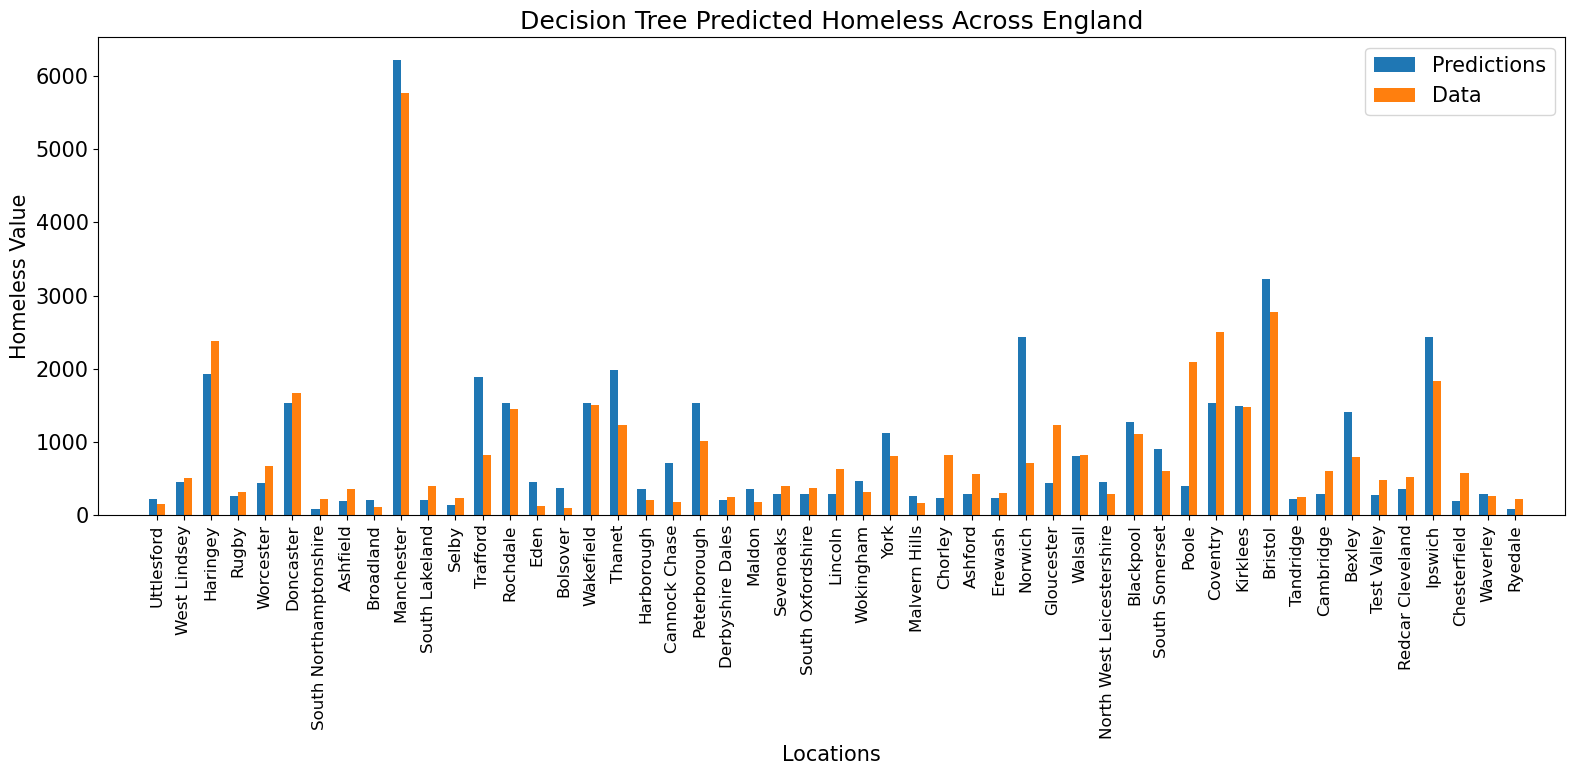

In [87]:
#Plot and save the test results
f_predictions = predictions
test_y = test_class_set

N =len(f_predictions)
locations = range(1,N+1)

# Position of bars on x-axis
y_pos = np.arange(N)

# Width of a bar 
width = 0.3

# Plotting
plt.rcParams.update({'font.size': 15})
fig_r2, ax = plt.subplots(figsize=(16,8))
plt.bar(y_pos, f_predictions, width, label='Predictions')
plt.bar(y_pos + width, test_y, width, label='Data')
plt.xlabel('Locations')
plt.ylabel('Homeless Value')
plt.title('Decision Tree Predicted Homeless Across England')

# xticks()
plt.xticks(y_pos + width / 2, list(local_authority_names[normal_test_class_set.index]))
plt.setp(ax.get_xticklabels(), fontsize=12, rotation='vertical')

# Size of the Plot
plt.xlim([-2,max(y_pos)+2])

# Finding the best position for legends and putting it
plt.legend(loc='best')
plt.tight_layout()
plt.savefig('Figure/ERIC_Random_forest_test_result.png')
plt.show()

In [88]:
accuracy_list = []
importance = pd.DataFrame(training_set.columns, columns=["feature"])
features = pd.DataFrame(training_set.columns, columns=["feature"])
loop_fit_rf = RandomForestClassifier(random_state=0)
for i in range(0,20):
    local_training_set, local_test_set, local_class_set, local_test_class_set = train_test_split(feature_space,feature_class,test_size = 0.20,random_state = i)
    # Cleaning test sets to avoid future warning messages
    local_normal_class_set = local_class_set
    local_class_set = local_normal_class_set.values.ravel() 
    local_normal_test_class_set = local_test_class_set
    local_test_class_set = local_normal_test_class_set.values.ravel() 
    
    loop_fit_rf = loop_fit_rf.set_params(n_estimators = 400,criterion = 'entropy',max_features = 'auto',max_depth = 5)
    
    loop_fit_rf.fit(local_training_set, local_class_set)
    local_predictions = loop_fit_rf.predict(local_test_set)
    
    accuracy = r2_score(local_test_class_set,local_predictions)
    accuracy_list.append(accuracy)

    importances_values = loop_fit_rf.feature_importances_
    
    columns_name = "importance" + str(i)
    importances = pd.DataFrame(importances_values, columns=[columns_name])
    importance = pd.concat([importance, importances], axis=1)


    importance = importance.sort_values([columns_name], ascending=True)
    importance[columns_name] = (importance[columns_name]).astype(float)
    importance = importance.sort_values([columns_name])
    
    thisImportance =  pd.concat([features, importances], axis=1)
    
    thisImportance = thisImportance.sort_values([columns_name], ascending=True)
    thisImportance[columns_name] = (thisImportance[columns_name]).astype(float)
    thisImportance = thisImportance.sort_values([columns_name])

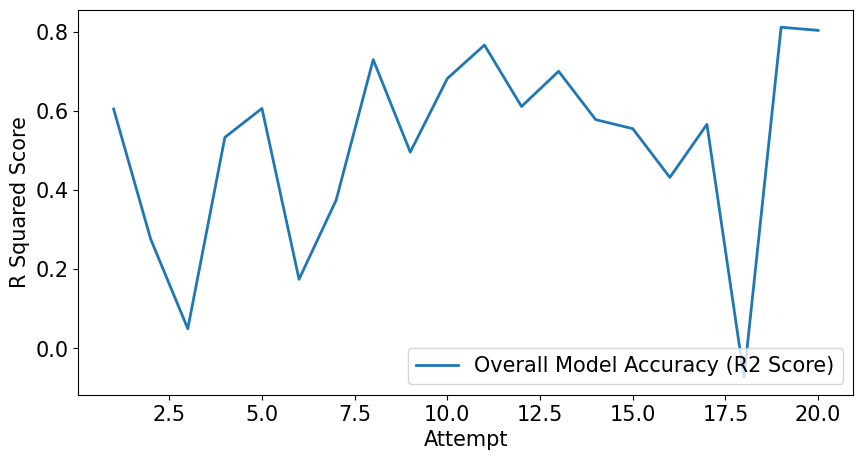

In [89]:
numbering = list(range(1,len(accuracy_list)+1))
plt.rcParams.update({'font.size': 15})
fig3, ax = plt.subplots(figsize=(10,5))
plt.plot(numbering, accuracy_list,linestyle ="-",linewidth=2, label = "Overall Model Accuracy (R2 Score)")
plt.xlabel('Attempt')
plt.ylabel('R Squared Score')
plt.legend(loc=4, prop={'size': 15})
plt.savefig('ERIC_accuracy_random_forest.png',bbox_inches='tight')

In [90]:
importance.index = importance['feature']
importance = importance.drop(labels='feature',axis=1)
average_importance = importance.mean(axis=1)

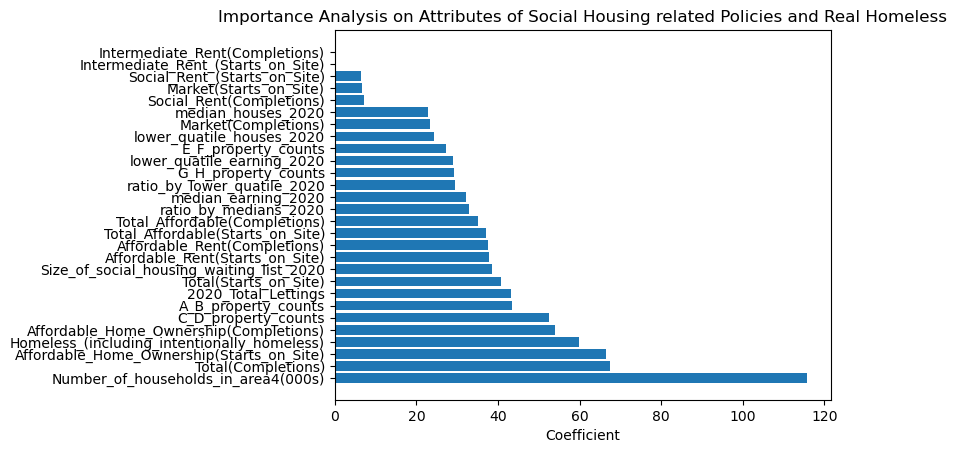

In [91]:
socre_data_score = pd.DataFrame(average_importance*1000)
socre_data_score.index = average_importance.index
socre_data_score = socre_data_score.sort_values(by=[0])
plt.rcdefaults()
fig, ax = plt.subplots()

feature_importance_score = np.array(socre_data_score[0])

# Example data
x_names = list(socre_data_score.index[:])
y_pos = np.arange(len(x_names))

ax.barh(y_pos, feature_importance_score, align='center')
ax.invert_yaxis()  # labels read top-to-bottom
ax.set_yticks(y_pos)
ax.set_yticklabels(list(x_names))
ax.set_xlabel('Coefficient')
ax.set_title('Importance Analysis on Attributes of Social Housing related Policies and Real Homeless')
plt.savefig('Figure/ERIC_overall_random_forest_importance_score_analysis.png',bbox_inches='tight')
plt.show()

In [92]:
feature_importance = pd.DataFrame(average_importance*1000)
feature_importance.columns = ['RF Importance']
feature_importance.index = average_importance.index
cwd = os.getcwd()
feature_importance.to_csv(os.path.join(cwd, "ResultTables/ERIC_overall_randome_forest_model_scores.csv"))  

In [27]:
data_table=categorical_data.drop(labels='Local',axis=1)
data_table=data_table.drop(labels='Local_Authority_code',axis=1)
data_table=data_table.drop(labels='Local_Authority_name',axis=1)
#data_table=data_table.drop(labels='Homeless_(including_intentionally_homeless)',axis=1)
data_table=data_table.drop(labels='Threatened_with_homelessness_within_56_days_Prevention_duty_owed',axis=1)
data_table=data_table.drop(labels='Homeless_Relief_duty_owed4',axis=1)
data_table=data_table.drop(labels='Total_households_with_support_needs',axis=1)
data_table=data_table.drop(labels='Total_secured_accommodation',axis=1)
data_table=data_table.drop(labels='Intermediate_Rent(Completions)',axis=1)
data_table=data_table.drop(labels='Intermediate_Rent_(Starts_on_Site)',axis=1)
#data_table=data_table.drop(labels='Social_Rent_(Starts_on_Site)',axis=1)
#data_table=data_table.drop(labels='Market(Completions)',axis=1)
#data_table=data_table.drop(labels='Social_Rent(Completions)',axis=1)
#data_table=data_table.drop(labels='Intermediate_Rent_(Starts_on_Site)',axis=1)
#data_table=data_table.drop(labels='Intermediate_Rent(Completions)',axis=1)
#data_table=data_table.drop(labels='Affordable_Home_Ownership(Starts_on_Site)',axis=1)
#data_table=data_table.drop(labels='Affordable_Home_Ownership(Completions)',axis=1)
#data_table=data_table.drop(labels='Market(Starts_on_Site)',axis=1)
#data_table=data_table.drop(labels='Market(Completions)',axis=1)
#data_table=data_table.drop(labels='C_D_property_counts',axis=1)
#data_table=data_table.drop(labels='E_F_property_counts',axis=1)
#data_table=data_table.drop(labels='G_H_property_counts',axis=1)
#data_table=data_table.drop(labels='median_houses_2020',axis=1)
#data_table=data_table.drop(labels='median_earning_2020',axis=1)
#data_table=data_table.drop(labels='ratio_by_medians_2020',axis=1)
#data_table=data_table.drop(labels='Total_Affordable(Starts_on_Site)',axis=1)
#data_table=data_table.drop(labels='Total_Affordable(Completions)',axis=1)
#data_table=data_table.drop(labels='Total(Starts_on_Site)',axis=1)
#data_table=data_table.drop(labels='Total(Completions)',axis=1)
#data_table=data_table.drop(labels='lower_quatile_houses_2020',axis=1)
#data_table=data_table.drop(labels='lower_quatile_earning_2020',axis=1)

In [28]:
data_table.columns

Index(['Total_owed_a_prevention_or_relief_duty',
       'Number_of_households_in_area4(000s)',
       'Homeless_(including_intentionally_homeless)',
       'Size_of_social_housing_waiting_list_2020', '2020_Total_Lettings',
       'Affordable_Rent(Starts_on_Site)', 'Social_Rent_(Starts_on_Site)',
       'Affordable_Home_Ownership(Starts_on_Site)',
       'Total_Affordable(Starts_on_Site)', 'Affordable_Rent(Completions)',
       'Social_Rent(Completions)', 'Affordable_Home_Ownership(Completions)',
       'Total_Affordable(Completions)', 'Total(Starts_on_Site)',
       'Total(Completions)', 'Market(Starts_on_Site)', 'Market(Completions)',
       'A_B_property_counts', 'C_D_property_counts', 'E_F_property_counts',
       'G_H_property_counts', 'median_houses_2020', 'median_earning_2020',
       'ratio_by_medians_2020', 'lower_quatile_houses_2020',
       'lower_quatile_earning_2020', 'ratio_by_lower_quatile_2020'],
      dtype='object')

In [29]:
feature_space = 0
feature_class = 0
feature_space = data_table.iloc[:, data_table.columns != 'Total_owed_a_prevention_or_relief_duty'].astype('float')
feature_class = data_table.iloc[:, data_table.columns == 'Total_owed_a_prevention_or_relief_duty'].astype('int')

In [30]:
# Set the random state for reproducibility
fit_rf = RandomForestClassifier(random_state=0)

In [45]:
# Run Exhaustive Search for optimal parameters
np.random.seed(0)
start = time.time()

param_dist = {'n_estimators':[400,500,600],'max_depth': [2,3,5],
              'max_features': ['auto', 'sqrt', None],
              'criterion': ['entropy']}

cv_rf = GridSearchCV(fit_rf, cv = 3,
                     param_grid=param_dist, 
                     n_jobs = 5)

cv_rf.fit(training_set, class_set)
print('Best Parameters using grid search: \n', 
      cv_rf.best_params_)
end = time.time()
print('Time taken in grid search: {0: .2f}'.format(end - start))

D:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:676: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  warnings.warn(


Best Parameters using grid search: 
 {'criterion': 'entropy', 'max_depth': 2, 'max_features': 'auto', 'n_estimators': 400}
Time taken in grid search:  53.06


In [39]:
accuracy_list = []
importance_new = pd.DataFrame(feature_space.columns, columns=["feature"])
features_new = pd.DataFrame(feature_class.columns, columns=["feature"])
loop_fit_rf_new = RandomForestClassifier(random_state=0)
for i in range(0,20):
    local_training_set, local_test_set, local_class_set, local_test_class_set = train_test_split(feature_space,feature_class,test_size = 0.20,random_state = i)
    # Cleaning test sets to avoid future warning messages
    local_normal_class_set = local_class_set
    local_class_set = local_normal_class_set.values.ravel() 
    local_normal_test_class_set = local_test_class_set
    local_test_class_set = local_normal_test_class_set.values.ravel() 
    
    loop_fit_rf = loop_fit_rf.set_params(n_estimators = 400,criterion = 'entropy',max_features = None,max_depth = 5)
    
    loop_fit_rf.fit(local_training_set, local_class_set)
    local_predictions = loop_fit_rf.predict(local_test_set)
    
    accuracy = r2_score(local_test_class_set,local_predictions)
    accuracy_list.append(accuracy)

    importances_values = loop_fit_rf.feature_importances_
    
    columns_name = "importance" + str(i)
    importances_new = pd.DataFrame(importances_values, columns=[columns_name])
    importance_new = pd.concat([importance_new, importances_new], axis=1)


    importance_new = importance_new.sort_values([columns_name], ascending=True)
    importance_new[columns_name] = (importance_new[columns_name]).astype(float)
    importance_new = importance_new.sort_values([columns_name])

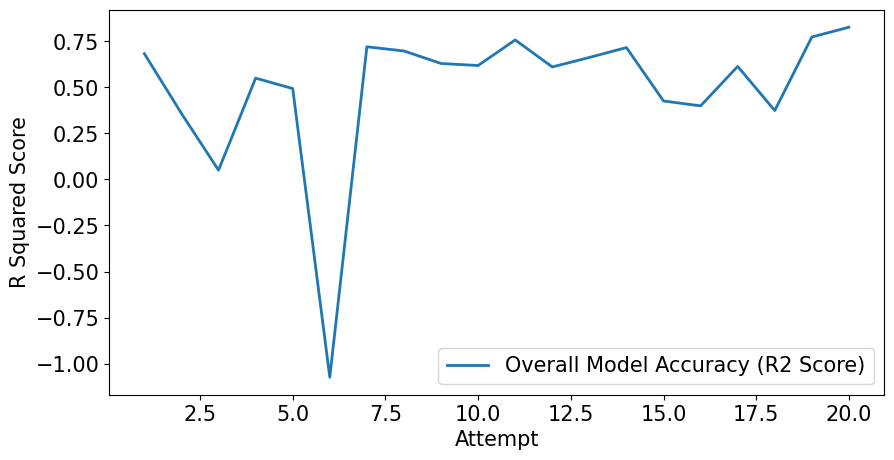

In [40]:
numbering = list(range(1,len(accuracy_list)+1))
plt.rcParams.update({'font.size': 15})
fig3, ax = plt.subplots(figsize=(10,5))
plt.plot(numbering, accuracy_list,linestyle ="-",linewidth=2, label = "Overall Model Accuracy (R2 Score)")
plt.xlabel('Attempt')
plt.ylabel('R Squared Score')
plt.legend(loc=4, prop={'size': 15})
plt.savefig('ERIC_accuracy_random_forest_new.png',bbox_inches='tight')

In [41]:
importance_new.index = importance_new['feature']
importance_new = importance_new.drop(labels='feature',axis=1)
average_importance = importance_new.mean(axis=1)

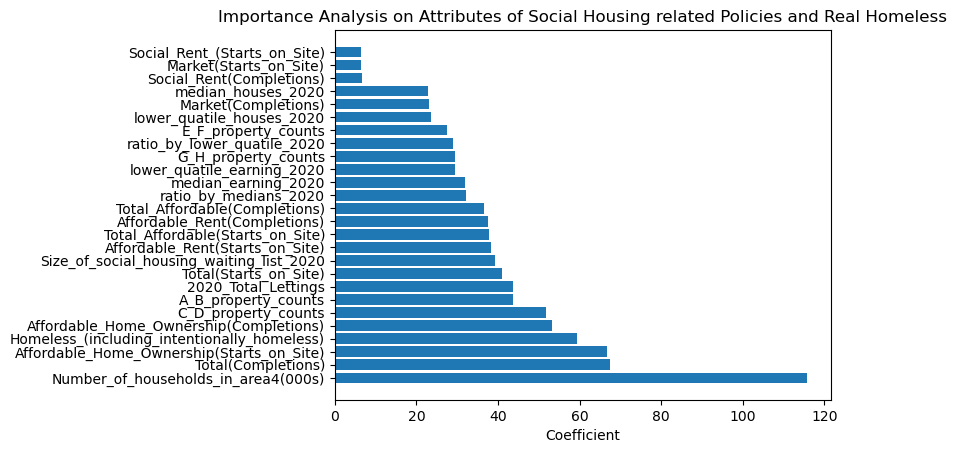

In [42]:
socre_data_score = pd.DataFrame(average_importance*1000)
socre_data_score.index = average_importance.index
socre_data_score = socre_data_score.sort_values(by=[0])
plt.rcdefaults()
fig, ax = plt.subplots()

feature_importance_score = np.array(socre_data_score[0])

# Example data
x_names = list(socre_data_score.index[:])
y_pos = np.arange(len(x_names))

ax.barh(y_pos, feature_importance_score, align='center')
ax.invert_yaxis()  # labels read top-to-bottom
ax.set_yticks(y_pos)
ax.set_yticklabels(list(x_names))
ax.set_xlabel('Coefficient')
ax.set_title('Importance Analysis on Attributes of Social Housing related Policies and Real Homeless')
plt.savefig('Figure/ERIC_new_overall_random_forest_importance_score_analysis.png',bbox_inches='tight')
plt.show()

In [43]:
feature_importance = pd.DataFrame(average_importance*1000)
feature_importance.columns = ['RF Importance']
feature_importance.index = average_importance.index
cwd = os.getcwd()
feature_importance.to_csv(os.path.join(cwd, "ResultTables/ERIC_new_overall_randome_forest_model_scores.csv"))  

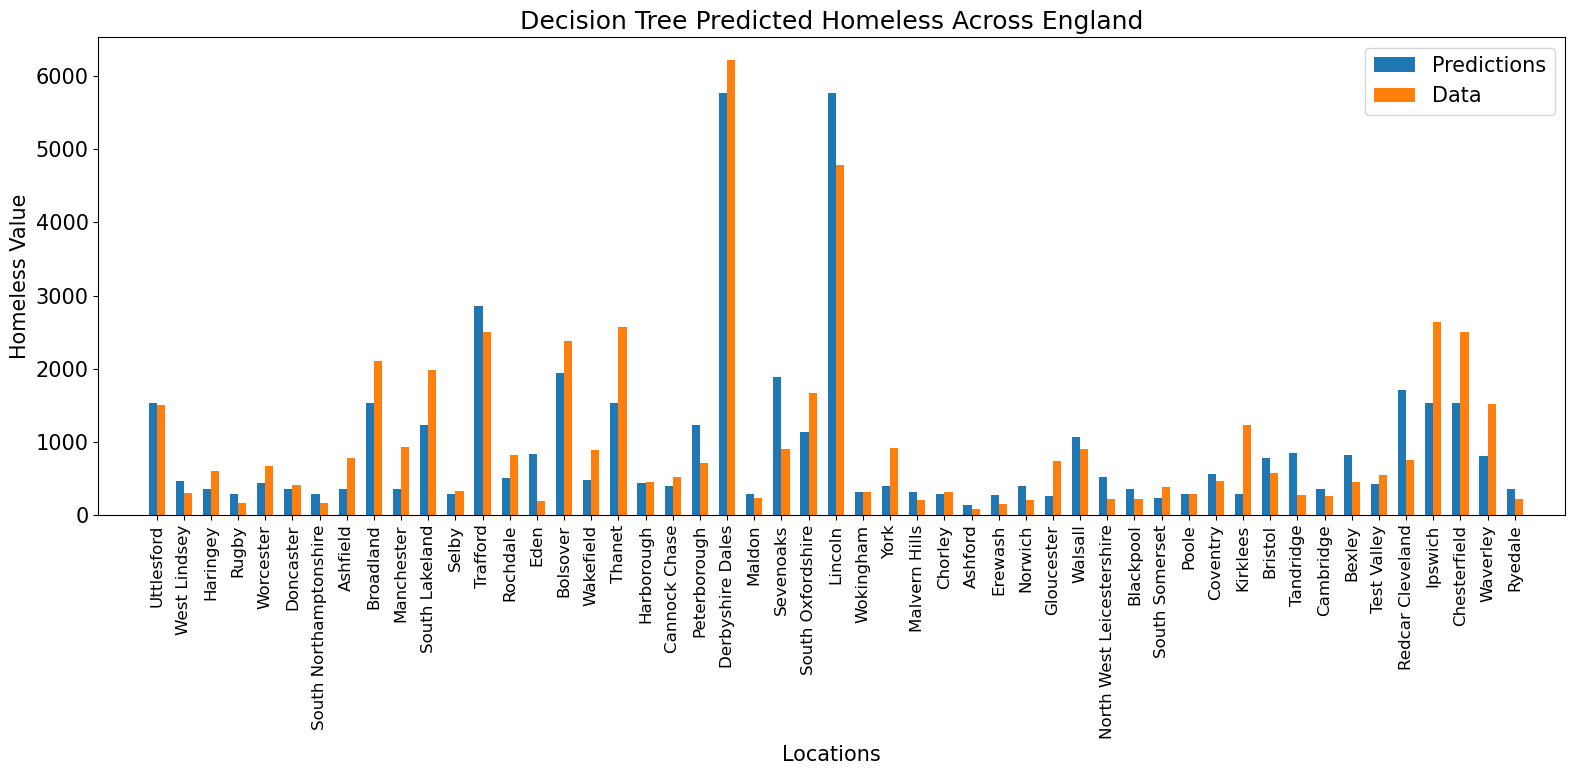

In [44]:
#Plot and save the test results
f_predictions = local_predictions
test_y = local_test_class_set

N =len(f_predictions)
locations = range(1,N+1)

# Position of bars on x-axis
y_pos = np.arange(N)

# Width of a bar 
width = 0.3

# Plotting
plt.rcParams.update({'font.size': 15})
fig_r2, ax = plt.subplots(figsize=(16,8))
plt.bar(y_pos, f_predictions, width, label='Predictions')
plt.bar(y_pos + width, test_y, width, label='Data')
plt.xlabel('Locations')
plt.ylabel('Homeless Value')
plt.title('Decision Tree Predicted Homeless Across England')

# xticks()
plt.xticks(y_pos + width / 2, list(local_authority_names[normal_test_class_set.index]))
plt.setp(ax.get_xticklabels(), fontsize=12, rotation='vertical')

# Size of the Plot
plt.xlim([-2,max(y_pos)+2])

# Finding the best position for legends and putting it
plt.legend(loc='best')
plt.tight_layout()
plt.savefig('Figure/ERIC_new_Random_forest_test_result.png')
plt.show()